# Read Data

Download the 2022 Combined flight data .parquet file from here (https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022) into the ../data folder before running any code.

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import warnings
warnings.filterwarnings("ignore")

# columns = ["Cancelled", "DepDelayMinutes", "Distance", "Airline", "Dest", "DestStateName", "Origin", "OriginStateName", "DayOfWeek", "CRSDepTime", "DepTimeBlk", "Month"]
columns = ["Cancelled", "DepDelayMinutes", "Distance", "Airline", "DayOfWeek", "DepTimeBlk", "Month"]

df = pd.read_parquet('../data/Combined_Flights_2022.parquet', columns=columns)

print(df.columns)
print(df.shape)

Index(['Cancelled', 'DepDelayMinutes', 'Distance', 'Airline', 'DayOfWeek',
       'DepTimeBlk', 'Month'],
      dtype='object')
(4078318, 7)


# Construct New Columns

In [2]:
# Turn departure delay column into categorical features
df['OnTime'] = df['DepDelayMinutes'] == 0
df['SlightDelay'] = (df['DepDelayMinutes'] <= 15) & (df['DepDelayMinutes'] > 0)
df['MediumDelay'] = (df['DepDelayMinutes'] <= 45) & (df['DepDelayMinutes'] > 15)
df['LargeDelay'] = df['DepDelayMinutes'] > 45

# Make sure these categories are "one-hot" encoded
df.loc[df['Cancelled'], 'OnTime'] = False
df.loc[df['Cancelled'], 'SlightDelay'] = False
df.loc[df['Cancelled'], 'MediumDelay'] = False
df.loc[df['Cancelled'], 'LargeDelay'] = False

# Merge the columns into a single label
df['FlightStatus'] = df[['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay']].idxmax(1).astype('category')

print(df.shape)

(4078318, 12)


# Splitting and Preprocessing 

In [3]:
# Check for missing values
perc_missing_per_ftr = df.isnull().sum(axis=0)/df.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

# Replace NaN features with 0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0)

fraction of missing values in features:
DepDelayMinutes    0.029545
dtype: float64


In [4]:
X = df.drop(['Cancelled','OnTime','SlightDelay','MediumDelay','LargeDelay', 'DepDelayMinutes', 'FlightStatus'], axis=1)
y = df['FlightStatus']

# ML Pipeline and Model Inspection

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score

def ML_pipeline(X, y, param_grid, fit_function, random_state, manageable_fraction_of_data=0.1):
    # first split to separate out the training set
    X_managable, _, y_managable, _ = train_test_split(X,y,train_size = manageable_fraction_of_data, random_state=random_state)
    X_train, X_other, y_train, y_other = train_test_split(X_managable,y_managable,train_size = 0.95, random_state=random_state)

    # second split to separate out the validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(X_other,y_other,train_size = 0.5,random_state=random_state)

    # Preprocess features
    onehot_ftrs = ["Airline", "DayOfWeek", "DepTimeBlk", "Month"]
    std_ftrs = ['Distance']

    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
            ('std', StandardScaler(), std_ftrs)])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    X_train_prep = pipeline.fit_transform(X_train)
    X_val_prep = pipeline.transform(X_val)
    X_test_prep = pipeline.transform(X_test)

    feature_names = np.array(preprocessor.get_feature_names_out())

    # we save the train and validation scores
    # the validation scores are necessary to select the best model
    train_score = np.zeros(len(ParameterGrid(param_grid)))
    val_score = np.zeros(len(ParameterGrid(param_grid)))
    models = []

    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        print(f"\tCurrent parameters: {params}")
        eval_set = [(X_val_prep, y_val)]
        
        fit_model = fit_function(X_train_prep, y_train, eval_set, params)
        models.append(fit_model) # save it
        
        # calculate train and validation accuracy scores
        y_train_pred = fit_model.predict(X_train_prep)
        train_score[p] = accuracy_score(y_train, y_train_pred)
        y_val_pred = fit_model.predict(X_val_prep)
        val_score[p] = accuracy_score(y_val, y_val_pred)
        print('   ',train_score[p], val_score[p])

    print('best model parameters:',ParameterGrid(param_grid)[np.argmax(val_score)])
    print('corresponding validation score:',np.max(val_score))
    # collect and save the best model
    final_model = models[np.argmax(val_score)]
    # calculate and save the test score
    y_test_pred = final_model.predict(X_test_prep)
    test_score = accuracy_score(y_test,y_test_pred)
    print('test score:',test_score)
    return final_model, test_score, X_test_prep, y_test, feature_names

In [57]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import shap

def understand_results(tag, model, test_score, X_test_prep, y_test, feature_names, 
                       confusion_matrix=True, 
                       roc_curve=False,
                       permutation_feature_importance=False,
                       xgboost_importances=False,
                       shap_importance=False,
                       shap_tree_importance=False):
    if confusion_matrix:
        disp = ConfusionMatrixDisplay.from_estimator(model, X_test_prep, y_test, display_labels=['Cancelled','LargeDelay','MediumDelay','OnTime','SlightDelay'], xticks_rotation='vertical')
        disp.plot()
        plt.title(f"{tag} Overall Confusion Matrix")
        plt.tight_layout()
        plt.xticks(rotation='vertical')
        plt.savefig(f'../figures/{tag}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    if roc_curve:
        fpr, tpr, p_crits = roc_curve(y_test, model.predict_proba(X_test_prep))
        plt.plot(fpr,tpr)
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title(f'{tag} ROC curve')
        plt.show()

    if permutation_feature_importance:
        y_pred = model.predict(X_test_prep)
        result = permutation_importance(model, X_test_prep, y_test, n_repeats=10, random_state=0)
        sorted_indcs = np.argsort(result.importances_mean)[::-1][:10][::-1]
        plt.rcParams.update({'font.size': 13})
        plt.boxplot(test_score-result.importances[sorted_indcs].T, labels=feature_names[sorted_indcs], vert=False)
        plt.axvline(test_score, label='test score')
        plt.title(f"{tag} Permutation Importances (test set)")
        plt.xlabel('Score with perturbed feature')
        plt.ylabel("Features")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'../figures/{tag}_permutation_feature_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    if xgboost_importances:
        for type in ["weight", "gain", "cover", "total_cover", "total_gain"]:
            importances = model.get_booster().get_score(importance_type=type)
            importances_keys = np.array(list(importances.keys()))
            importances_values = np.array(list(importances.values()))
            sorted_indcs = np.argsort(importances_values)[::-1][:10][::-1]

            plt.barh(list(range(10)), importances_values[sorted_indcs], align='center')
            plt.yticks(list(range(10)), feature_names[sorted_indcs])
            plt.ylabel("Features")
            plt.xlabel("Feature importance")
            plt.title(f"XGBoost Feature Importance: {type}")
            plt.savefig(f'../figures/{tag}_xgboost_feature_importance_{type}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
    if shap_importance:
        shap.initjs()
        explainer = shap.KernelExplainer(model.predict_proba, X_test_prep)
        shap_values = explainer.shap_values(X_test_prep)
        shap.bar_plot(np.mean(np.abs(shap_values[0]), axis=0), feature_names=feature_names, max_display=10, show=False)
        plt.title(f'{tag} SHAP Global Feature Importance')
        plt.savefig(f'../figures/{tag}_shap_global.png', dpi=300, bbox_inches='tight')
        plt.show()

        index = 0
        shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_prep[index, :], feature_names = feature_names, show=False, matplotlib=True)
        plt.title(f'{tag} SHAP Local Feature Importance')
        plt.savefig(f'../figures/{tag}_shap_local.png', dpi=300, bbox_inches='tight')
        plt.show()

    if shap_tree_importance:
        shap.initjs()
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_prep)
        shap.bar_plot(np.mean(np.abs(shap_values[0]), axis=0), feature_names=feature_names, max_display=10, show=False)
        plt.title(f'{tag} SHAP Global Feature Importance')
        plt.savefig(f'../figures/{tag}_shap_global.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        index = 0
        shap.force_plot(explainer.expected_value[0], shap_values[0][index,:], features = X_test_prep[index, :], feature_names = feature_names, show=False, matplotlib=True)
        plt.title(f'{tag} SHAP Local Feature Importance')
        plt.savefig(f'../figures/{tag}_shap_local.png', dpi=300, bbox_inches='tight')
        plt.show()
        

# Results: XGBoost

In [25]:
import xgboost

def XGB_fit_function(X_train_prep, y_train, eval_set, params):    
    XGB = xgboost.XGBClassifier(n_jobs=-1, use_label_encoder=True, verbosity = 0)
    XGB.set_params(**params)
    XGB.fit(X_train_prep, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=False) 
    return XGB

num_random_states = 3

XGB_test_scores = []
XGB_models = []
XGB_X_test_preps = []
XGB_y_tests = []
XGB_feature_names_list = []

for i in range(num_random_states):
    print(f'Random state: {i}')
    random_state = i * 42
    XGB_param_grid = {
        "learning_rate": [0.03],
        "n_estimators": [100],
        "seed": [random_state], 
        "max_depth": [1,3,10],
        "colsample_bytree": [0.9],              
        "subsample": [0.66],
        "eval_metric": [accuracy_score],
    }
    XGB_model, XGB_test_score, XGB_X_test_prep, XGB_y_test, XGB_feature_names = ML_pipeline(X, y, XGB_param_grid, XGB_fit_function, random_state, manageable_fraction_of_data=0.01)
    
    XGB_models.append(XGB_model)
    XGB_test_scores.append(XGB_test_score)
    XGB_X_test_preps.append(XGB_X_test_prep)
    XGB_y_tests.append(XGB_y_test)
    XGB_feature_names_list.append(XGB_feature_names)

print(f'Mean of test scores: {np.mean(XGB_test_scores)}')
print(f'STD of test scores: {np.std(XGB_test_scores)}')

Random state: 0
	Current parameters: {'subsample': 0.66, 'seed': 0, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.03, 'eval_metric': <function accuracy_score at 0x13d0d4550>, 'colsample_bytree': 0.9}
    0.5909454611155563 0.6107843137254902
	Current parameters: {'subsample': 0.66, 'seed': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.03, 'eval_metric': <function accuracy_score at 0x13d0d4550>, 'colsample_bytree': 0.9}
    0.5909712722298222 0.6107843137254902
	Current parameters: {'subsample': 0.66, 'seed': 0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.03, 'eval_metric': <function accuracy_score at 0x13d0d4550>, 'colsample_bytree': 0.9}
    0.6185117311514338 0.6068627450980392
best model parameters: {'subsample': 0.66, 'seed': 0, 'n_estimators': 100, 'max_depth': 1, 'learning_rate': 0.03, 'eval_metric': <function accuracy_score at 0x13d0d4550>, 'colsample_bytree': 0.9}
corresponding validation score: 0.6107843137254902
test score: 0.57549019607843

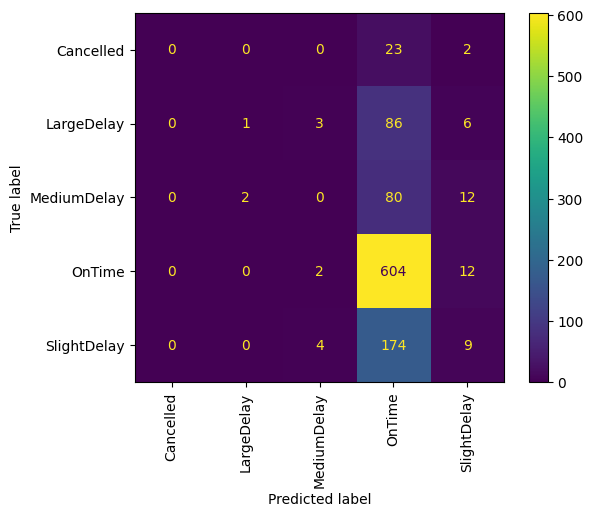

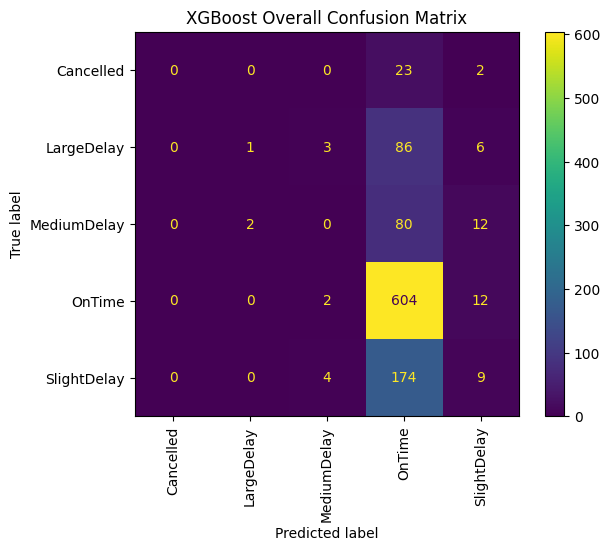

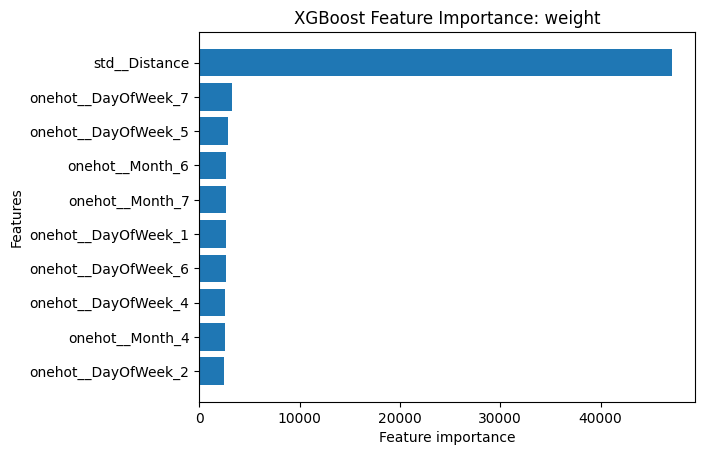

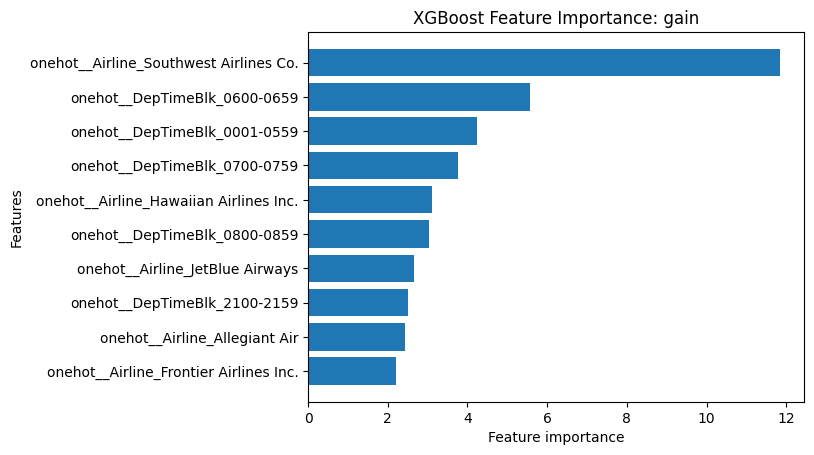

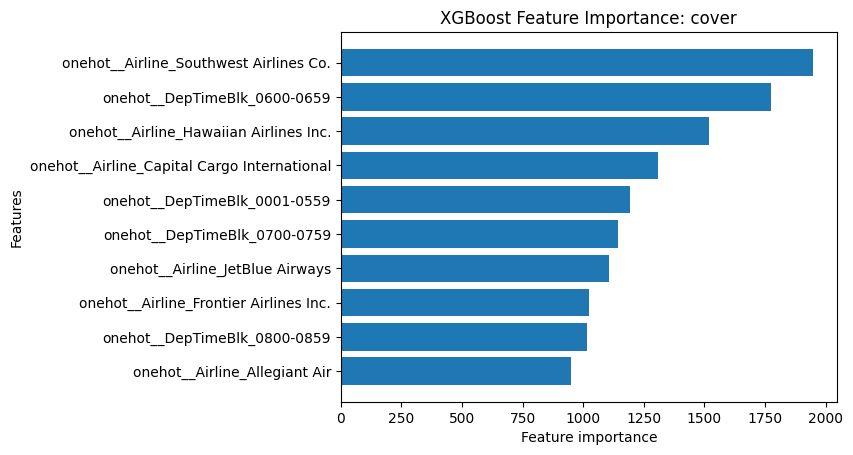

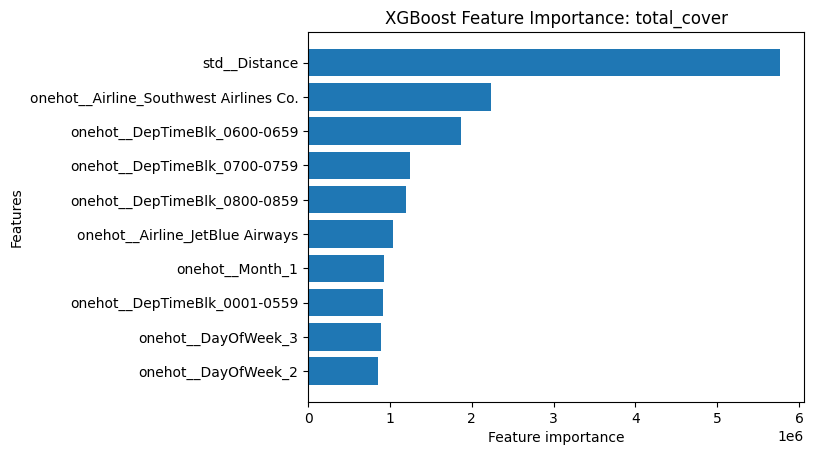

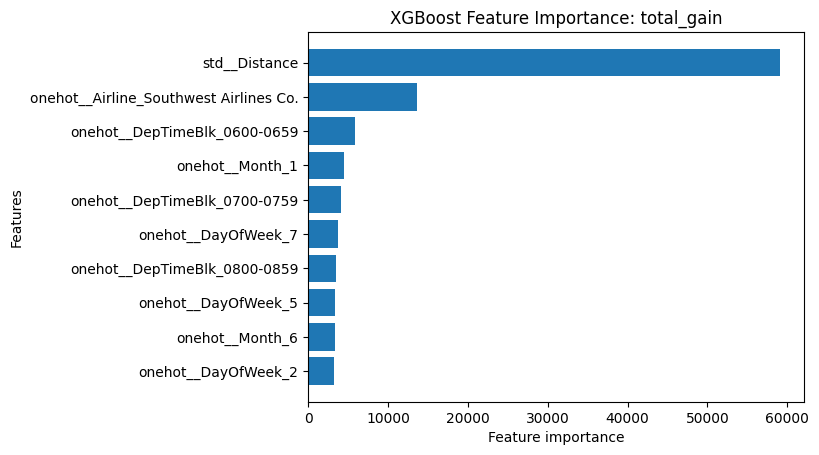

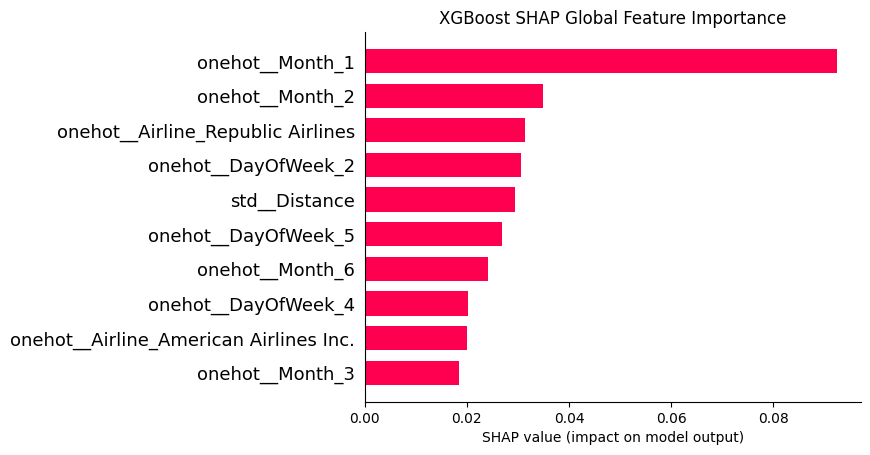

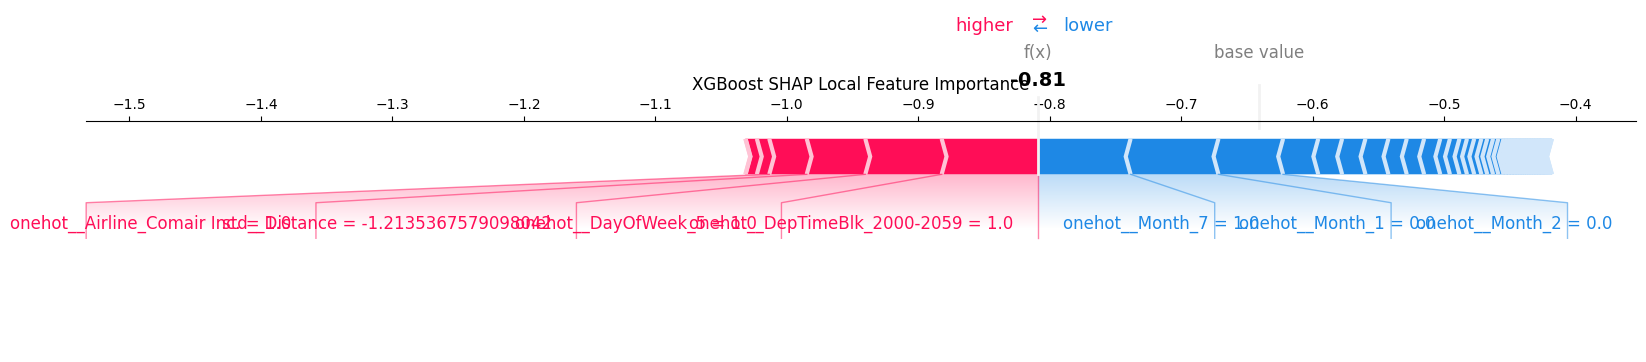

In [55]:
best_index = np.argmax(XGB_test_scores)
understand_results('XGBoost', XGB_models[best_index], XGB_test_scores[best_index], XGB_X_test_preps[best_index], XGB_y_tests[best_index], XGB_feature_names_list[best_index], xgboost_importances=True, shap_tree_importance=True, roc_curve=False)

In [66]:
from sklearn.metrics import f1_score 

f1_model = f1_score(XGB_y_tests[best_index], XGB_models[best_index].predict(XGB_X_test_preps[best_index]), average='weighted')
print(f1_model)
f1_baseline = f1_score(XGB_y_tests[best_index], ['OnTime' for _ in range(1020)], average='weighted')
print(f1_baseline)

0.4688504990160799
0.4488056166672677


# Results: RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

def RF_fit_function(X_train_prep, y_train, eval_set, params):
    model = RandomForestClassifier()
    model.set_params(**params)
    model.fit(X_train_prep, y_train)
    return model

RF_param_grid = {
    'max_depth': [3, 10, 30]
}

RF_models = []
RF_test_scores = []
RF_X_test_preps = []
RF_y_tests = []
RF_feature_names_list = []

num_random_states = 3
for i in range(num_random_states):
    random_state = i*42
    RF_model, RF_test_score, RF_X_test_prep, RF_y_test, RF_feature_names = ML_pipeline(X, y, RF_param_grid, RF_fit_function, random_state)
    
    RF_models.append(RF_model)
    RF_test_scores.append(RF_test_score)
    RF_X_test_preps.append(RF_X_test_prep)
    RF_y_tests.append(RF_y_test)
    RF_feature_names_list.append(RF_feature_names)
    
print(f'Mean of test scores: {np.mean(RF_test_scores)}')
print(f'STD of test scores: {np.std(RF_test_scores)}')

	Current parameters: {'max_depth': 3}
    0.5886733137345492 0.5883679874460572
	Current parameters: {'max_depth': 10}
    0.5886733137345492 0.5883679874460572
	Current parameters: {'max_depth': 30}
    0.7917143085750273 0.5457041977245979
best model parameters: {'max_depth': 3}
corresponding validation score: 0.5883679874460572
test score: 0.5858179678305218
	Current parameters: {'max_depth': 3}
    0.5877828509778313 0.5801294625343272
	Current parameters: {'max_depth': 10}
    0.5878215667498625 0.5801294625343272
	Current parameters: {'max_depth': 30}
    0.7926357439493701 0.5324637112593174
best model parameters: {'max_depth': 3}
corresponding validation score: 0.5801294625343272
test score: 0.5938603373872107
	Current parameters: {'max_depth': 3}
    0.5872176007061757 0.5926834052569635
	Current parameters: {'max_depth': 10}
    0.5872176007061757 0.5926834052569635
	Current parameters: {'max_depth': 30}
    0.7936526782280565 0.5503138485680659
best model parameters: {'max_d

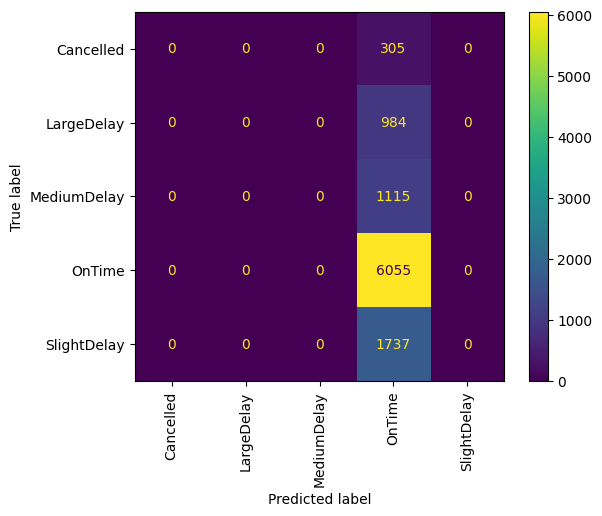

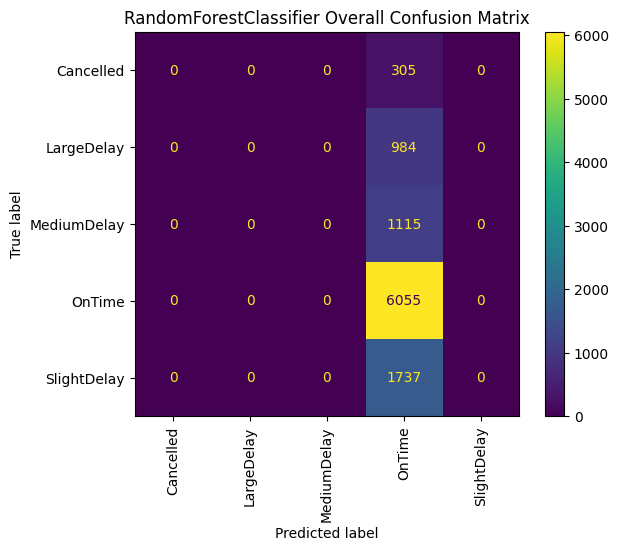

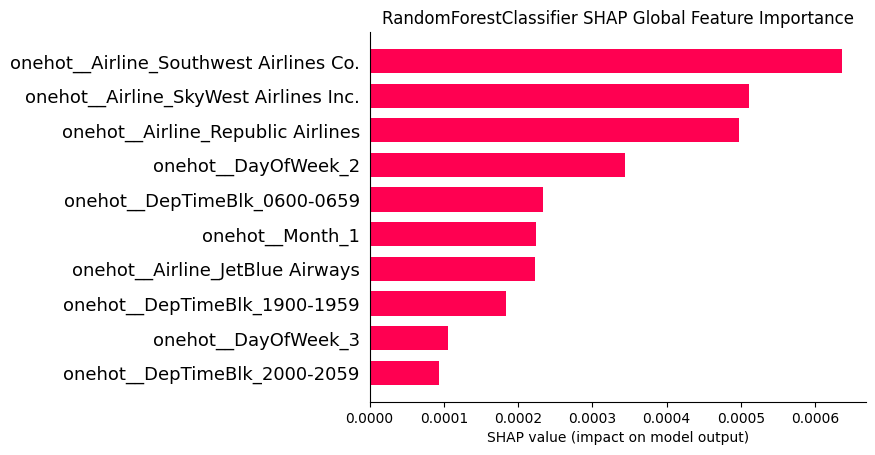

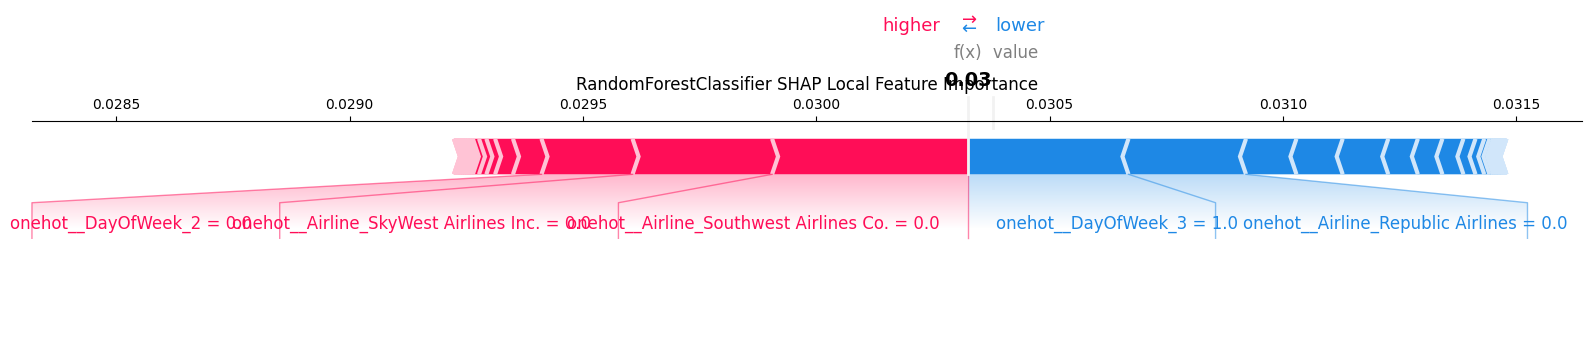

In [58]:
best_index = np.argmax(RF_test_scores)
understand_results('RandomForestClassifier', RF_models[best_index], RF_test_scores[best_index], RF_X_test_preps[best_index], RF_y_tests[best_index], RF_feature_names_list[best_index], xgboost_importances=False, shap_tree_importance=True)

In [68]:
f1_model = f1_score(RF_y_tests[best_index], RF_models[best_index].predict(RF_X_test_preps[best_index]), average='weighted')
print(f1_model)
f1_baseline = f1_score(RF_y_tests[best_index], ['OnTime' for _ in range(10196)], average='weighted')
print(f1_baseline)

0.44253576307667963
0.44253576307667963


# Results: KNeighborsClassifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_fit_function(X_train_prep, y_train, eval_set, params):
    model = KNeighborsClassifier()
    model.set_params(**params)
    model.fit(X_train_prep, y_train)
    return model

KNN_param_grid = {
    "n_neighbors": [10, 30, 100, 1000]
}

KNN_models = []
KNN_test_scores = []
KNN_X_test_preps = []
KNN_y_tests = []
KNN_feature_names_list = []

num_random_states = 3
for i in range(num_random_states):
    random_state = i*42
    KNN_model, KNN_test_score, KNN_X_test_prep, KNN_y_test, KNN_feature_names = ML_pipeline(X, y, KNN_param_grid, KNN_fit_function, random_state)
    
    KNN_models.append(KNN_model)
    KNN_test_scores.append(KNN_test_score)
    KNN_X_test_preps.append(KNN_X_test_prep)
    KNN_y_tests.append(KNN_y_test)
    KNN_feature_names_list.append(KNN_feature_names)
    
print(f'Mean of test scores: {np.mean(KNN_test_scores)}')
print(f'STD of test scores: {np.std(KNN_test_scores)}')

	Current parameters: {'n_neighbors': 10}
    0.6221521323356709 0.5654178109062378
	Current parameters: {'n_neighbors': 30}
    0.6039970163045021 0.589152608866222
	Current parameters: {'n_neighbors': 100}
    0.5964526028613537 0.5961161239701844
	Current parameters: {'n_neighbors': 1000}
    0.5893856839399234 0.5883679874460572
best model parameters: {'n_neighbors': 100}
corresponding validation score: 0.5961161239701844
test score: 0.5917026284817576
	Current parameters: {'n_neighbors': 10}
    0.6222708607032332 0.5598273832875638
	Current parameters: {'n_neighbors': 30}
    0.6026471263863473 0.5806198509219301
	Current parameters: {'n_neighbors': 100}
    0.5957350705530419 0.5867006669282071
	Current parameters: {'n_neighbors': 1000}
    0.5883532633524245 0.5807179285994508
best model parameters: {'n_neighbors': 100}
corresponding validation score: 0.5867006669282071
test score: 0.5972930561004316
	Current parameters: {'n_neighbors': 10}
    0.621395884255328 0.57483326794821

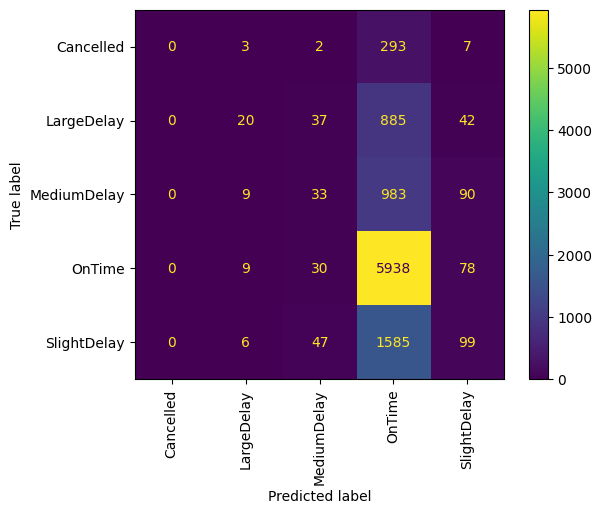

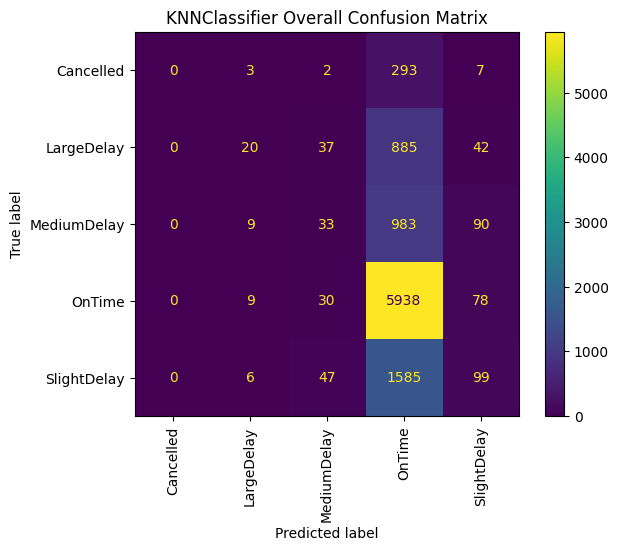

  0%|          | 0/10 [00:00<?, ?it/s]

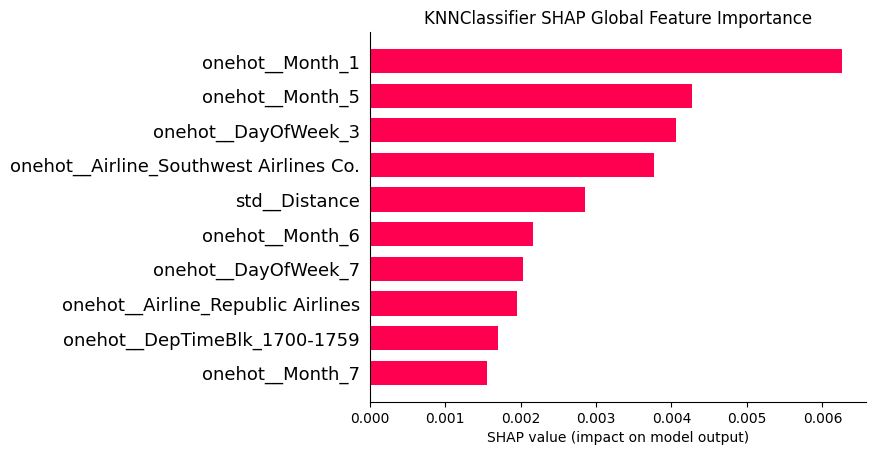

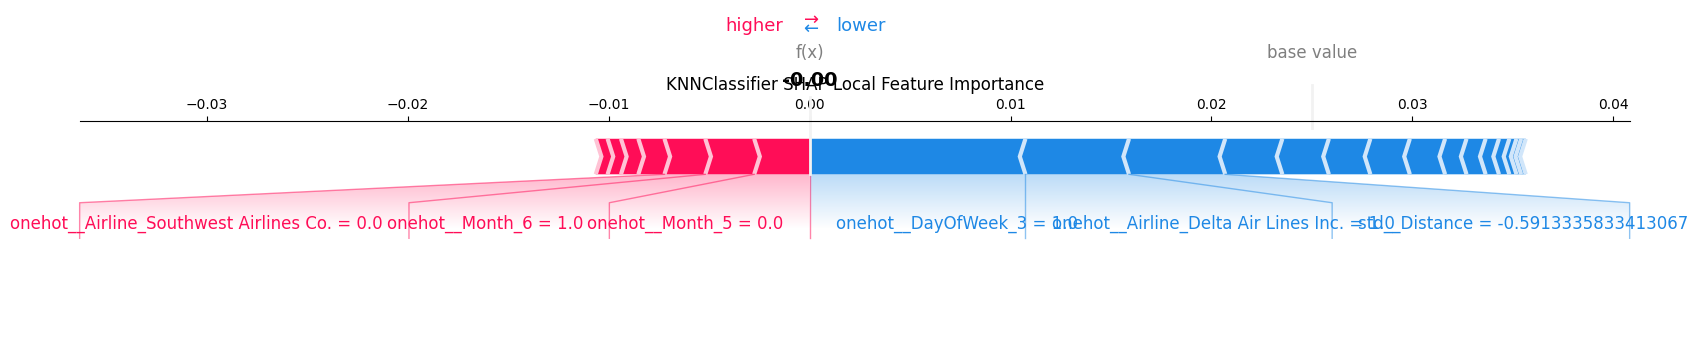

In [59]:
best_index = np.argmax(KNN_test_scores)
understand_results('KNNClassifier', KNN_models[best_index], KNN_test_scores[best_index], KNN_X_test_preps[best_index], KNN_y_tests[best_index], KNN_feature_names_list[best_index])
understand_results('KNNClassifier', KNN_models[best_index], KNN_test_scores[best_index], KNN_X_test_preps[best_index][:10, :], KNN_y_tests[best_index][10:], KNN_feature_names_list[best_index], confusion_matrix=False, shap_importance=True)

In [69]:
f1_model = f1_score(KNN_y_tests[best_index], KNN_models[best_index].predict(KNN_X_test_preps[best_index]), average='weighted')
print(f1_model)
f1_baseline = f1_score(KNN_y_tests[best_index], ['OnTime' for _ in range(10196)], average='weighted')
print(f1_baseline)

0.4739871768937129
0.44253576307667963


# Results: LogisticRegression

In [47]:
from sklearn.linear_model import LogisticRegression

def LR_fit_function(X_train_prep, y_train, eval_set, params):
    clf = LogisticRegression(random_state=0)
    clf.set_params(**params)
    clf.fit(X_train_prep,y_train) 
    return clf

LR_param_grid = {
    "penalty": ['l2', 'none'],
    "C": [0.1, 0.5, 0.9],
    "n_jobs": [-1],
    "max_iter": [10000],
}

LR_models = []
LR_test_scores = []
LR_X_test_preps = []
LR_y_tests = []
LR_feature_names_list = []

num_random_states = 3
for i in range(num_random_states):
    random_state = i*42
    LR_model, LR_test_score, LR_X_test_prep, LR_y_test, LR_feature_names = ML_pipeline(X, y, LR_param_grid, LR_fit_function, random_state)
    
    LR_models.append(LR_model)
    LR_test_scores.append(LR_test_score)
    LR_X_test_preps.append(LR_X_test_prep)
    LR_y_tests.append(LR_y_test)
    LR_feature_names_list.append(LR_feature_names)
    
print(f'Mean of test scores: {np.mean(LR_test_scores)}')
print(f'STD of test scores: {np.std(LR_test_scores)}')

	Current parameters: {'penalty': 'l2', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.1}
    0.5905368328949847 0.5896429972538251
	Current parameters: {'penalty': 'none', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.1}
    0.590534251843516 0.5896429972538251
	Current parameters: {'penalty': 'l2', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.5}
    0.5905316707920473 0.5896429972538251
	Current parameters: {'penalty': 'none', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.5}
    0.590534251843516 0.5896429972538251
	Current parameters: {'penalty': 'l2', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.9}
    0.5905316707920473 0.5896429972538251
	Current parameters: {'penalty': 'none', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.9}
    0.590534251843516 0.5896429972538251
best model parameters: {'penalty': 'l2', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.1}
corresponding validation score: 0.5896429972538251
test score: 0.5867987446057278
	Current parameters: {'penalty': 'l2', 'n_jobs': -1, 'max_iter': 10000, 'C': 0.1}
    0

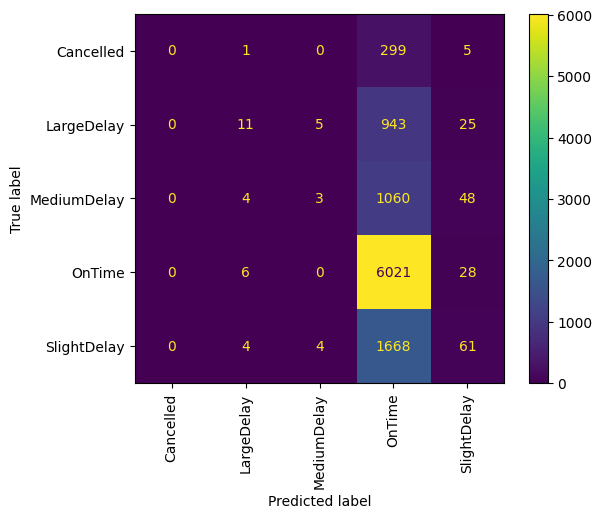

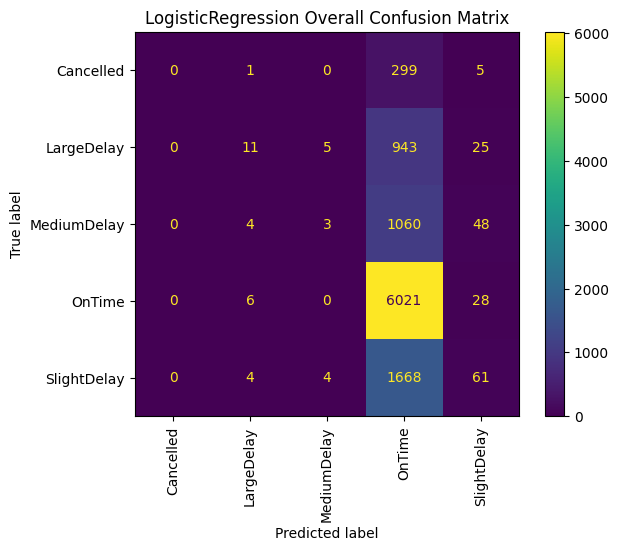

In [60]:
best_index = np.argmax(LR_test_scores)
understand_results('LogisticRegression', LR_models[best_index], LR_test_scores[best_index], LR_X_test_preps[best_index], LR_y_tests[best_index], LR_feature_names_list[best_index])

In [70]:
f1_model = f1_score(LR_y_tests[best_index], LR_models[best_index].predict(LR_X_test_preps[best_index]), average='weighted')
print(f1_model)
f1_baseline = f1_score(LR_y_tests[best_index], ['OnTime' for _ in range(10196)], average='weighted')
print(f1_baseline)

0.4592731748994135
0.44253576307667963
